## AddDimensionView Op

In [1]:
//load ImageJ
%classpath config resolver scijava.public https://maven.scijava.org/content/groups/public
%classpath add mvn net.imagej imagej 2.0.0-rc-67

//create ImageJ object
ij = new net.imagej.ImageJ()

Added new repo: scijava.public


net.imagej.ImageJ@3baf5137

This `Op` wraps the `Views.addDimension()` method of ImgLib2, adding another dimension to a n-dimensional `RandomAccessible` or `RandomAccessibleInterval`. Let's see how the `Op` is called: 

In [2]:
ij.op().help('addDimensionView')

Available operations:
	(IntervalView out) =
	net.imagej.ops.transform.addDimensionView.AddDimensionViewMinMax(
		RandomAccessibleInterval in,
		long minOfNewDim,
		long maxOfNewDim)
	(MixedTransformView out) =
	net.imagej.ops.transform.addDimensionView.DefaultAddDimensionView(
		RandomAccessible in)

Note that if our image is on an `Interval` then we have to pass through minimum and maximum coordinates for the new dimension that we are adding. Let's show this with an image:

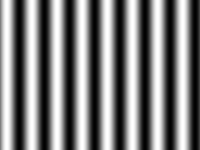

In [3]:
import net.imglib2.FinalInterval
import net.imglib2.img.Img
import net.imglib2.type.numeric.integer.UnsignedByteType

dims = new FinalInterval(200, 150)

input = ij.op().create().img(dims, new UnsignedByteType())
equation = "127 * Math.sin(p[0] / 4) + 128"
ij.op().run("equation", input, equation)

ij.notebook().display(input)

Here is a two-dimensional image. Let's make it 3 dimensional. Because it is on an `Interval` we will have to pass through a minimum and a maximum:

[199, 149, 1]


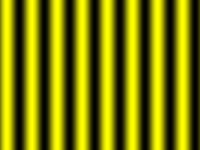

In [4]:
minimum = 0
maximum = 1

largerImg = ij.op().run("addDimensionView", input, minimum, maximum)

max = new long[largerImg.numDimensions()]

largerImg.max(max)

println(Arrays.toString(max))

ij.notebook().display(largerImg)

Now we have **color**! Note that the image displays as yellow because `addDimension` **does not** actually create any new data locations. Instead the `Op` **discards any information about the new dimension** when accessing the value at that location, thus leaving any `(x, y, z)` coordinate that we intend on accessing with the `(x, y)` coordinate that we know we have data for. Let's drive this point home with an example:

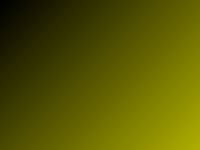

In [5]:
cursor = largerImg.cursor()
while(cursor.hasNext()){
    cursor.fwd()
    if(cursor.getLongPosition(2) == 0){
        //if we are in the first z slice DO NOTHING
    }
    if(cursor.getLongPosition(2) == 1){
        //if we are in the second z slice create a ramp
        cursor.get().set(((cursor.getLongPosition(0) + cursor.getLongPosition(1)) / 2) as byte)
    }
}

ij.notebook().display(largerImg)

Note that our old sin pattern is completely overwritten. This is because (as stated above) `addDimension` creates an image where any reference to the new dimension is **dropped** when accessing a particular value. Better said,

1. Even though in the last code segment we are only changing the value when the cursor is in the second z slice our `Op` our output image does **not** actually have a third dimension, instead dropping that third coordinate and then accessing the two-dimensional image at that point. This is why the sin pattern is overwritten in **both** slices.
2. The image is yellow because as far as the our display method knows our image has two dimensions (which are painted as red and green), however because this image is really just a two-dimensional image with the cursor dropping the third dimension, we are getting the same intensity values for each slice (i.e. color). Equal amounts of red and green make yellow, hence the yellow image.